In [1]:
from keras.models import Model
from keras.layers import Input, Conv1D, Dense, Activation, Dot, Flatten, Reshape, MaxPooling1D, Dropout
from keras.optimizers import Adam
from keras.backend import l2_normalize
from sklearn.model_selection import train_test_split
from keras.utils import Sequence
from keras.callbacks import EarlyStopping
import typing
from keras.layers import Conv1D, BatchNormalization, Dropout, Dense, Flatten, Concatenate, Reshape, Input

import random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from datagenerator import DataGenerator

physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len (physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

KeyboardInterrupt: 

Files: ['sub-008_-_audiobook_6_1.npz', 'sub-008_-_audiobook_6_2.npz', 'sub-008_-_audiobook_2_1.npz', 'sub-008_-_audiobook_5_1.npz', 'sub-008_-_audiobook_5_3.npz', 'sub-008_-_audiobook_5_2.npz', 'sub-008_-_audiobook_4.npz', 'sub-008_-_audiobook_3.npz', 'sub-008_-_audiobook_1.npz']
Files: ['sub-008_-_audiobook_6_1.npz', 'sub-008_-_audiobook_6_2.npz', 'sub-008_-_audiobook_2_1.npz', 'sub-008_-_audiobook_5_1.npz', 'sub-008_-_audiobook_5_3.npz', 'sub-008_-_audiobook_5_2.npz', 'sub-008_-_audiobook_4.npz', 'sub-008_-_audiobook_3.npz', 'sub-008_-_audiobook_1.npz']
Epoch 1/50


2023-04-20 12:28:39.738630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-20 12:28:43.590720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 - 5s - loss: 0.6922 - accuracy: 0.5189 - val_loss: 0.6873 - val_accuracy: 0.6181 - 5s/epoch - 611ms/step
Epoch 2/50
9/9 - 3s - loss: 0.6672 - accuracy: 0.7550 - val_loss: 0.6701 - val_accuracy: 0.7014 - 3s/epoch - 366ms/step
Epoch 3/50
9/9 - 2s - loss: 0.6235 - accuracy: 0.8226 - val_loss: 0.6319 - val_accuracy: 0.6944 - 2s/epoch - 180ms/step
Epoch 4/50
9/9 - 2s - loss: 0.5419 - accuracy: 0.8515 - val_loss: 0.5831 - val_accuracy: 0.7153 - 2s/epoch - 179ms/step
Epoch 5/50
9/9 - 2s - loss: 0.3913 - accuracy: 0.9044 - val_loss: 0.5632 - val_accuracy: 0.6944 - 2s/epoch - 172ms/step
Epoch 6/50
9/9 - 2s - loss: 0.2089 - accuracy: 0.9581 - val_loss: 0.6164 - val_accuracy: 0.7222 - 2s/epoch - 174ms/step
Epoch 7/50
9/9 - 2s - loss: 0.0848 - accuracy: 0.9950 - val_loss: 0.6356 - val_accuracy: 0.7500 - 2s/epoch - 173ms/step
Epoch 8/50
9/9 - 2s - loss: 0.0323 - accuracy: 0.9983 - val_loss: 0.7605 - val_accuracy: 0.6806 - 2s/epoch - 172ms/step
Epoch 9/50
9/9 - 2s - loss: 0.0117 - accuracy: 1.00

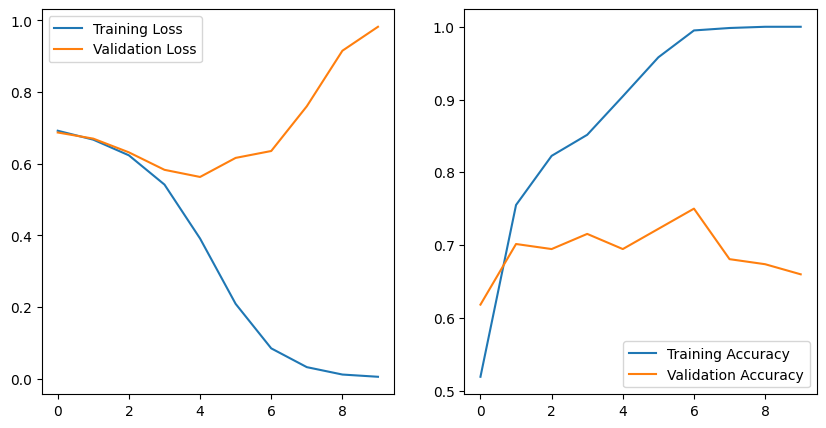

In [ ]:
data_folder = os.getcwd() + '/data/eeg'
all_files = [f for f in os.listdir(data_folder) if f.endswith('.npz')]

batch_size = 1
time_window = 10
subject = 'sub-008'

train_generator = DataGenerator(all_files, batch_size=batch_size, stage='train', time_window=time_window, subject=subject)
val_generator = DataGenerator(all_files, batch_size=batch_size, stage='val', time_window=time_window, subject=subject)

# BUILDING THE MODEL
time_window = train_generator.time_window
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

from keras.layers import LeakyReLU

eeg = Input(shape=(time_window, 64))
env1 = Input(shape=(time_window, 1))
env2 = Input(shape=(time_window, 1))

conv1 = Conv1D(filters=32, kernel_size=16, padding='same')(eeg)
conv1 = BatchNormalization()(conv1)
conv1 = LeakyReLU()(conv1)
# conv1 = Dropout(0.3)(conv1)

conv2 = Conv1D(filters=64, kernel_size=8, padding='same')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = LeakyReLU()(conv2)
# conv2 = Dropout(0.3)(conv2)

conv3 = Conv1D(filters=128, kernel_size=4, padding='same')(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = LeakyReLU()(conv3)
# conv3 = Dropout(0.3)(conv3)

cos_sim1 = tf.keras.layers.Dot(axes=(1, 1), normalize=True)([conv3, env1])
cos_sim2 = tf.keras.layers.Dot(axes=(1, 1), normalize=True)([conv3, env2])

# Classification
merged = tf.keras.layers.Flatten()(tf.keras.layers.Concatenate()([cos_sim1, cos_sim2]))
fc1 = Dense(64, activation="relu")(merged)
fc1 = Dropout(0.5)(fc1)
fc2 = Dense(32, activation="relu")(fc1)
out1 = Dense(1, activation="sigmoid")(fc2)

# 1 output per batch
out = tf.keras.layers.Reshape([1], name="output_name")(out1)
model = tf.keras.Model(inputs=[eeg, env1, env2], outputs=[out])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


# Fit the model
history = model.fit(train_generator, epochs=50, verbose=2, validation_data=val_generator, callbacks=[early_stopping])

training_loss = history.history['loss']
training_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracty = history.history['val_accuracy']

# Print the training and validation loss and accuracy
print("Training Loss:", training_loss)
print("Training Accuracy:", training_accuracy)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(training_loss, label='Training Loss')
axs[0].plot(val_loss, label='Validation Loss')
axs[0].legend()

axs[1].plot(training_accuracy, label='Training Accuracy')
axs[1].plot(val_accuracty, label='Validation Accuracy')
axs[1].legend()

plt.show()